# Comparing Models on the ExtraSensory dataset


## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

#Disable multi-threading in NumPy 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import mkl
mkl.get_max_threads()
mkl.set_num_threads(1)

1

## Import modules

In [2]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow uses a basic train/test experiment to compare the use of several different Scikit-Learn classification models including a "guess the majority class" model, decision trees, logistic regression, RBF kernel SVMs, and KNN. The experiment uses the first 50,000  instances in the ExtraSensory data set. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation, and normalization. Next, the workflow includes one branch performing a train/test experiment for each model. Pre-processing is shared across all branches of the workflow. 

In the results below, we can see a 15% spread in accuracy across methods. However, the model hyper-parameters have not been optimized for any of the models, so the comparison is relatively meaningless. The hyper-parameters need to first be optimized before the models can be compared. This can be accomplished by wrapping the estimators in Scikit-Learns grid search cross-validation wrapper. See ExtraSensory-ComparingModels-NestedCV.ipynb for an example of nesting cross validation within experimental protocols. 

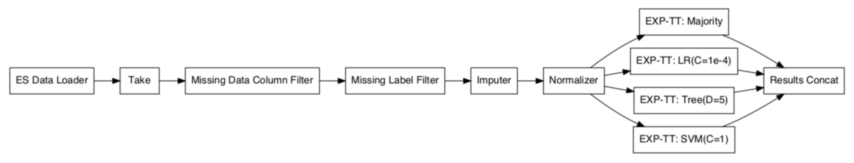

In [11]:
df_raw      = extrasensory_data_loader(label="SLEEPING");
df_raw      = Take(df_raw, 50000)
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

metrics     = [accuracy_score, f1_score, precision_score, recall_score]

models = {
              "Majority":   DummyClassifier(strategy="most_frequent"),
              "LR(C=1e-4)": LogisticRegression(C=1e-4, solver="lbfgs",max_iter=1000),
              "Tree(D=5)":  tree.DecisionTreeClassifier(max_depth=5),
              "SVM(C=1)":   SVC(C=1, gamma="auto", max_iter=100)
        }

res     = ExpTrainTest(df_norm, models, metrics=metrics);
res_cat = ResultsConcat(res)
flow    = workflow([df_norm,res_cat])
 
flow.draw(); plt.show();
output=flow.run(backend="sequential", monitor=True, from_scratch=True);

In [15]:
display(output["Results Concat"]["report"])

,accuracy_score,f1_score,precision_score,recall_score
Majority,0.671809,0.000000,0.000000,0.000000
LR(C=1e-4),0.824199,0.691921,0.814280,0.601530
Tree(D=5),0.745448,0.419632,0.833469,0.280404
SVM(C=1),0.747690,0.539833,0.672372,0.450943


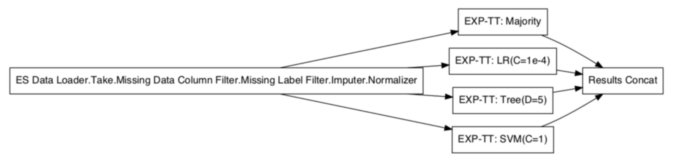

In [6]:
output=flow.run(backend="multiprocess_pipeline", num_workers=4,monitor=True, from_scratch=True);

In [8]:
display(output["Results Concat"]["report"])

,accuracy_score,f1_score,precision_score,recall_score
Majority,0.671809,0.000000,0.000000,0.000000
LR(C=1e-4),0.824199,0.691921,0.814280,0.601530
Tree(D=5),0.742937,0.409316,0.832355,0.271386
SVM(C=1),0.747690,0.539833,0.672372,0.450943
